In [3]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_subdirectories_paths(parent_path):
    """
    Get a list of paths to subdirectories in a specified directory.

    Args:
        parent_path (str): Path to the parent directory.

    Returns:
        list: List of paths to subdirectories.
    """
    # List comprehension to find all subdirectories
    return [os.path.join(parent_path, d) for d in os.listdir(parent_path) if os.path.isdir(os.path.join(parent_path, d))]

def get_file_paths(parent_path):
    """
    Get a list of paths to all files in a specified directory.

    Args:
        parent_path (str): Path to the parent directory.

    Returns:
        list: List of paths to files.
    """
    # List comprehension to find all files
    return [os.path.join(parent_path, f) for f in os.listdir(parent_path) if os.path.isfile(os.path.join(parent_path, f))]

def load_image(img_path):
    """
    Helper function to load an image and convert it to a numpy array.

    Parameters:
        img_path (str): Path to the image file.

    Returns:
        np.ndarray: Loaded image as a numpy array with shape (H, W) for grayscale images
                    or (H, W, C) for color images (e.g., RGB or RGBA).
    """
    img = Image.open(img_path)
    return np.array(img)

def plot_image(image: np.ndarray, title: str = "Image", cmap: str = None):
    """
    Plot an image with an optional title and colormap.

    Parameters:
        image (np.ndarray): The image to plot. Can be 2D (grayscale) or 3D (RGB/RGBA).
        title (str): The title of the plot. Default is "Image".
        cmap (str): Colormap to use if the image is grayscale (2D). Default is None.

    Returns:
        None
    """
    plt.figure(figsize=(6, 6))
    if image.ndim == 2:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_image(image: np.ndarray, save_path: str):
    """
    Save the image to a specified path.

    Parameters:
        image (np.ndarray): The image to save. Should be in RGB, RGBA, or grayscale format.
        save_path (str): Path to save the image, including the filename and extension.
    
    Returns:
        None
    """
    # Create directory if it does not exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Check if the input is a numpy array
    if not isinstance(image, np.ndarray):
        raise TypeError("Input must be a numpy array.")

    # Convert numpy array to Image object
    try:
        img_to_save = Image.fromarray(image)
    except ValueError as e:
        raise ValueError("Failed to convert numpy array to image. Ensure the array format is correct.") from e

    # Save image to the specified path
    try:
        img_to_save.save(save_path)
        print(f"Image successfully saved at: {save_path}")
    except Exception as e:
        raise IOError(f"Failed to save image at {save_path}.") from e

def plot_loss(losses, output_dir="output"):
    """
    Plot the loss over iterations and save the plot as a PNG image.

    Parameters:
        losses (list or np.ndarray): List or array of loss values for each iteration.
        output_dir (str): Directory to save the plot image. Default is "output".
    
    Returns:
        None
    """
    # Check if losses is not empty
    if not losses:
        raise ValueError("The 'losses' list is empty. Cannot plot loss.")

    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # Create the plot
    figure, ax = plt.subplots()
    ax.plot(losses, label='Loss', color='blue')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_title('Loss per Iteration')
    ax.legend()

    # Save the plot image
    save_path = os.path.join(output_dir, "loss.png")
    figure.savefig(save_path)
    print(f"Loss plot saved at: {save_path}")
    plt.close(figure)  # Close the figure to free up resources

def histogram(dct, x_label="Labels", y_label="Count", title="Number of Items per Label"):
    """
    Plot a histogram from a dictionary of label counts.

    Parameters:
        dct (dict): Dictionary with labels as keys and counts as values.
        x_label (str): Label for the x-axis. Default is "Labels".
        y_label (str): Label for the y-axis. Default is "Count".
        title (str): Title of the histogram. Default is "Number of Items per Label".
    
    Returns:
        None
    """
    plt.figure(figsize=(20, 8))
    plt.bar(dct.keys(), dct.values(), color='blue')
    plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='checkpoint.pth.tar', device='cpu'):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename,weights_only=True, map_location=device)
        return checkpoint
    else:
        return None

In [4]:
!pip install mtcnn

In [5]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN

def align_face(image, landmarks, H, W):
    """
    Aligns a face in an image based on detected facial landmarks.

    Parameters:
    image (numpy.ndarray): The input image containing the face to be aligned.
    landmarks (dict): A dictionary containing the detected facial landmarks with keys:
                      'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'.
    H (int): The desired height of the output aligned image.
    W (int): The desired width of the output aligned image.

    Returns:
    numpy.ndarray: The aligned face image with dimensions (H, W).
    """

    # Standard facial landmarks (center of the eyes, tip of the nose, corners of the mouth)
    desired_landmarks = np.array([
        [0.381 * W, 0.517 * H],  # Left eye
        [0.735 * W, 0.515 * H],  # Right eye
        [0.560 * W, 0.717 * H],  # Tip of the nose
        [0.415 * W, 0.924 * H],  # Left mouth corner
        [0.707 * W, 0.922 * H]   # Right mouth corner
    ], dtype=np.float32)

    # Detected landmarks from MTCNN
    detected_landmarks = np.float32([
        landmarks['left_eye'],
        landmarks['right_eye'],
        landmarks['nose'],
        landmarks['mouth_left'],
        landmarks['mouth_right']
    ])
    
    # Calculate the affine transformation matrix
    transformation_matrix, _ = cv2.estimateAffinePartial2D(detected_landmarks, desired_landmarks, method=cv2.LMEDS)
    
    # Apply the transformation to align the face
    aligned_image = cv2.warpAffine(image, transformation_matrix, (W, H))
    
    return aligned_image

def preprocess_face(dataset, prs_face="dataset/face/processed", not_prs_face="dataset/face/not_processed", H=112, W=112):
    """
    Preprocess faces in a dataset by detecting and aligning them.

    Parameters:
    dataset (str): Path to the dataset directory.
    prs_face (str): Path to save the processed face images. Default is "dataset/face/processed".
    not_prs_face (str): Path to save the images that do not contain faces. Default is "dataset/face/not_processed".
    H (int): The desired height of the output aligned image. Default is 112.
    W (int): The desired width of the output aligned image. Default is 112.

    Returns:
    None
    """
    detector = MTCNN()
    subs = get_subdirectories_paths(dataset)

    for sub in subs:
        paths = get_file_paths(sub)
        for path in paths:
            img = load_image(path)
            faces = detector.detect_faces(img)
            if len(faces) == 0:
                save_image(img, os.path.join(not_prs_face, os.path.basename(sub)[5:], os.path.basename(path)))
            else:
                for face in faces:
                    box = face['box']
                    landmarks = face['keypoints']

                    # Crop face from the original image
                    x, y, width, height = box
                    face_image = img[y:y+height, x:x+width]

                    # Adjust the coordinates of the landmarks according to the cropped region
                    adjusted_landmarks = {
                        'left_eye': (landmarks['left_eye'][0] - x, landmarks['left_eye'][1] - y),
                        'right_eye': (landmarks['right_eye'][0] - x, landmarks['right_eye'][1] - y),
                        'nose': (landmarks['nose'][0] - x, landmarks['nose'][1] - y),
                        'mouth_left': (landmarks['mouth_left'][0] - x, landmarks['mouth_left'][1] - y),
                        'mouth_right': (landmarks['mouth_right'][0] - x, landmarks['mouth_right'][1] - y)
                    }

                    # Align the face
                    aligned_face = align_face(face_image, adjusted_landmarks, H, W)
                    save_image(aligned_face, os.path.join(prs_face, os.path.basename(sub)[5:], os.path.basename(path)))

In [6]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch

class FaceRecognitionDataset(Dataset):
    def __init__(self, dataset):
        """
        Dataset class for face recognition.
        
        Args:
            dataset (str): Path to the dataset.
        """
        self.dataset = dataset
        self.file_paths = []
        self.labels = []
        self.dict_label = {}
        self.transform = transforms.ToTensor()  
        
        self._prepare_dataset()

    def _prepare_dataset(self):
        """Internal method to prepare file paths and labels."""
        subs = get_subdirectories_paths(self.dataset)
        for index, sub in enumerate(subs):
            self.dict_label[index] = os.path.basename(sub)
            file_paths = get_file_paths(sub)
            self.file_paths.extend(file_paths)
            self.labels.extend([index] * len(file_paths))

    def __len__(self):
        """Return the total number of samples."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Get an image and its label by index.
        
        Args:
            idx (int): Index of the image and label to return.
            
        Returns:
            tuple: (image, label)
        """
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None
        img = np.array(img)
        img = (img - 127.5)/128
        img = self.transform(img)
        return img, label, os.path.basename(img_path)

In [7]:
from torch import nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable

import math
from torch.nn import Parameter
bottleneck_setting = [
    # t, c , n ,s
    [2, 64, 5, 2],
    [4, 128, 1, 2],
    [2, 128, 6, 1],
    [4, 128, 1, 2],
    [2, 128, 2, 1]
]

class Bottleneck(nn.Module):
    def __init__(self, inp, oup, stride, expansion):
        super(Bottleneck, self).__init__()
        self.connect = stride == 1 and inp == oup
        self.conv = nn.Sequential(
            #pw
            nn.Conv2d(inp, inp * expansion, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),
            # nn.ReLU(inplace=True),

            #dw
            nn.Conv2d(inp * expansion, inp * expansion, 3, stride, 1, groups=inp * expansion, bias=False),
            nn.BatchNorm2d(inp * expansion),
            nn.PReLU(inp * expansion),
            # nn.ReLU(inplace=True),

            #pw-linear
            nn.Conv2d(inp * expansion, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class ConvBlock(nn.Module):
    def __init__(self, inp, oup, k, s, p, dw=False, linear=False, isBN = True):
        super(ConvBlock, self).__init__()
        self.linear = linear
        self.isBN = isBN
        if dw:
            self.conv = nn.Conv2d(inp, oup, k, s, p, groups=inp, bias=False)
        else:
            self.conv = nn.Conv2d(inp, oup, k, s, p, bias=False)
        if self.isBN:
            self.bn = nn.BatchNorm2d(oup)
        if not linear:
            self.prelu = nn.PReLU(oup)
    def forward(self, x):
        x = self.conv(x)
        if self.isBN:
            x = self.bn(x)
        if not self.linear:
            x = self.prelu(x)
        return x



class MobileFacenet(nn.Module):
    def __init__(self, bottleneck_setting=bottleneck_setting):
        super(MobileFacenet, self).__init__()

        self.conv1 = ConvBlock(3, 64, 3, 2, 1)

        self.dw_conv1 = ConvBlock(64, 64, 3, 1, 1, dw=True)

        self.inplanes = 64
        block = Bottleneck
        self.blocks = self._make_layer(block, bottleneck_setting)

        self.conv2 = ConvBlock(128, 512, 1, 1, 0)

        self.linear7 = ConvBlock(512, 512, 7, 1, 0, dw=True, linear=True, isBN = False)

        self.linear1 = ConvBlock(512, 128, 1, 1, 0, linear=True,isBN = False)
        self.output = nn.Linear(128, 105)
        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, setting):
        layers = []
        for t, c, n, s in setting:
            for i in range(n):
                if i == 0:
                    layers.append(block(self.inplanes, c, s, t))
                else:
                    layers.append(block(self.inplanes, c, 1, t))
                self.inplanes = c

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dw_conv1(x)
        x = self.blocks(x)
        x = self.conv2(x)
        x = self.linear7(x)
        x = self.linear1(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)

        return x

<h2>EDA</h1>

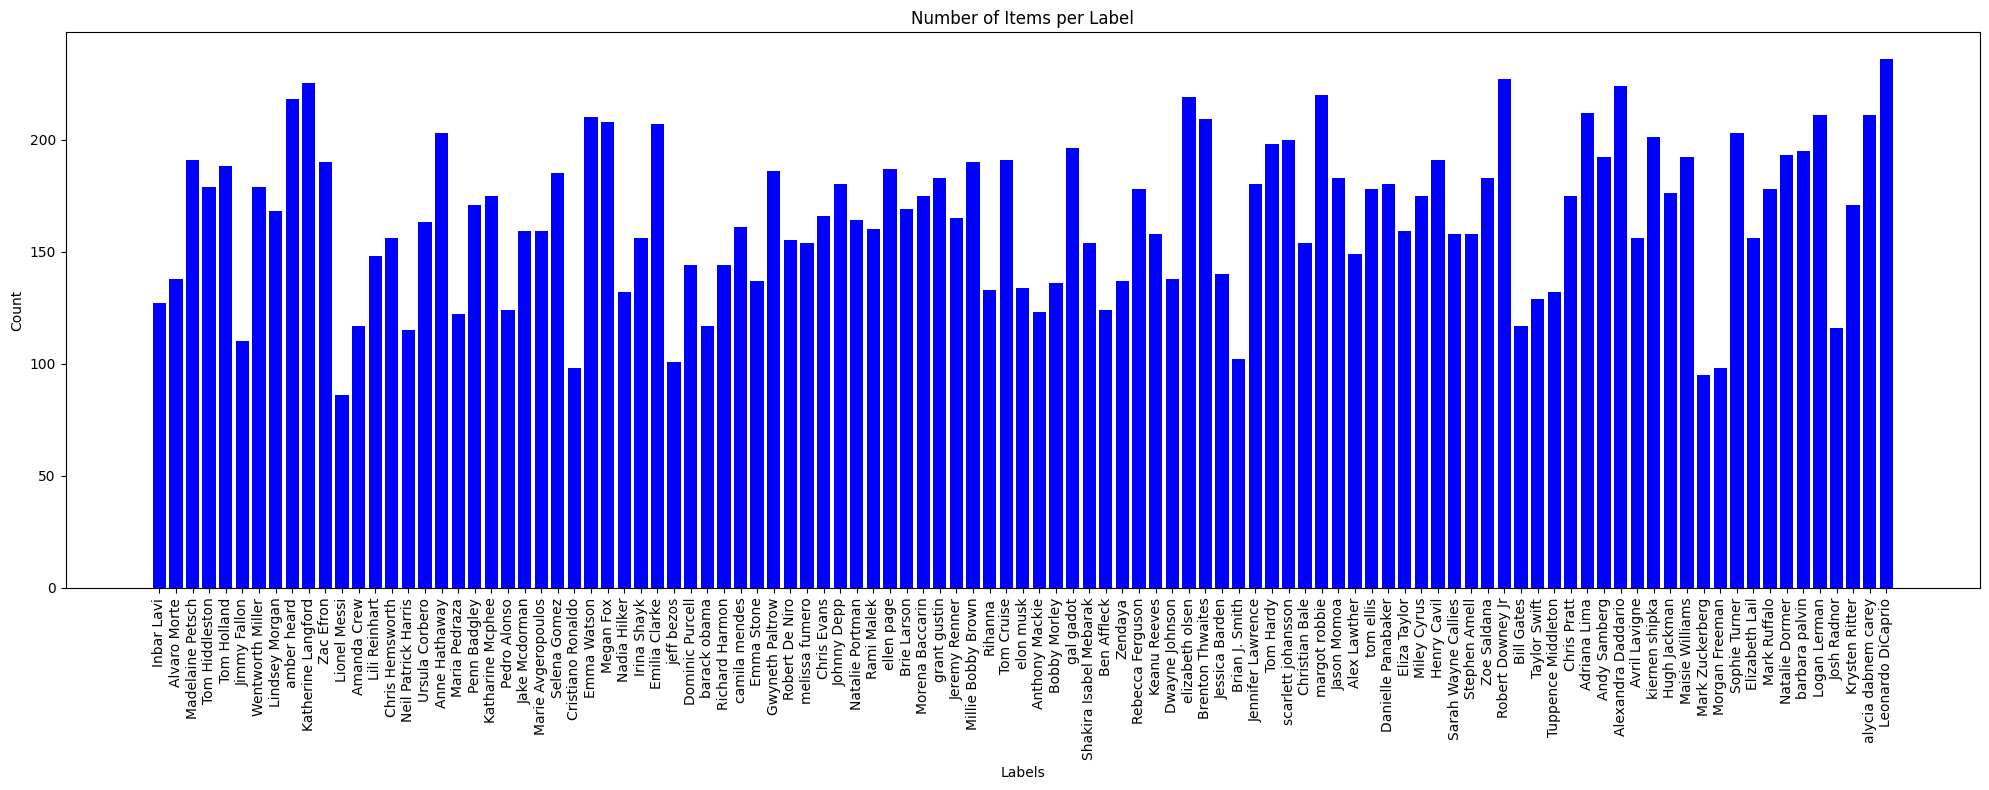

In [8]:

dataset_path = '/kaggle/input/facedataset/processed'
subs = get_subdirectories_paths(dataset_path)
file_counts = {os.path.basename(sub) : len(get_file_paths(sub)) for sub in subs}
histogram(file_counts)

<h1>Training</h1>

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.optim import AdamW

DATASET_ROOT = '/kaggle/input/facedataset/processed'
BATCH_SIZE = 256
EPOCHS = 100
CHECK_POINT = None
BEST_MODEL = None
SAVE_FREQ = 1
TEST_FREQ = 1

In [10]:
dataset = FaceRecognitionDataset(DATASET_ROOT)

In [11]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [12]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(valid_dataset)}')

Train dataset size: 13903
Test dataset size: 3476


torch.Size([3, 112, 112])
Zoe Saldana85_5052.jpg


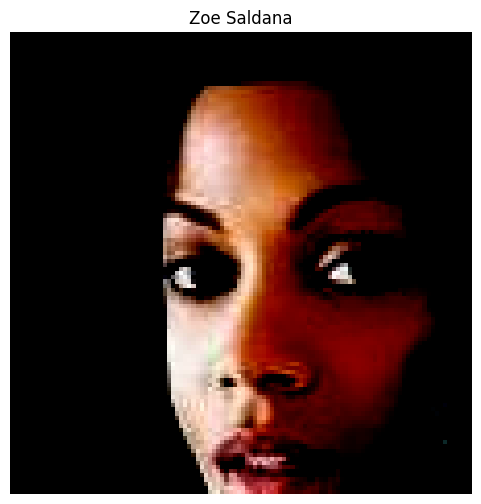

In [13]:
item = train_dataset[3]
print(item[0].shape)
print(item[2])
plot_image(item[0].permute(1,2,0),title=dataset.dict_label[item[1]])

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MobileFacenet()
net = net.to(device) 
if torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(net.parameters(), lr=1e-4)  

In [17]:
ckpt = load_checkpoint("/kaggle/input/mobilefacenet/pytorch/default/1/068.ckpt")
state_dict = ckpt['net_state_dict']
adjusted_state_dict = {}

for k, v in state_dict.items():
    if not (k.startswith('linear7') or k.startswith('linear1')):
        new_key = 'module.' + k
        adjusted_state_dict[new_key] = v

net.load_state_dict(adjusted_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['module.linear7.conv.weight', 'module.linear1.conv.weight', 'module.output.weight', 'module.output.bias'], unexpected_keys=[])

In [23]:
import time
import torch
from tqdm import tqdm

def train_per_epoch(net, trainloader, optimizer_ft, criterion, device):
    """
    Train the model for one epoch.

    Args:
    - net (torch.nn.Module): The neural network model.
    - trainloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer_ft (torch.optim.Optimizer): The optimizer used for training.
    - criterion (torch.nn.Module): The loss function.
    - ArcMargin (torch.nn.Module): The ArcMargin layer.
    - device (str): The device to run the training on ('cpu' or 'cuda').

    Returns:
    - avg_train_loss (float): The average training loss for the epoch.
    """
    
    net.train()
    train_total_loss = 0.0
    total = 0
    since = time.time()

    tqdm_bar = tqdm(trainloader, total=len(trainloader))
    for data in tqdm_bar:
        img, label = data[0].to(device).float(), data[1].to(device)
        batch_size = img.shape[0]
        optimizer_ft.zero_grad()

        logits = net(img)
        total_loss = criterion(logits, label)
        total_loss.backward()
        optimizer_ft.step()

        train_total_loss += total_loss.item() * batch_size
        total += batch_size

        # Update the progress bar with the current loss
        avg_loss = train_total_loss / total
        tqdm_bar.set_description(desc=f"Training Loss: {avg_loss:.5f}")

    avg_train_loss = train_total_loss / total
    return avg_train_loss

In [26]:
import torch
from tqdm import tqdm

def test_epoch(net, testloader, criterion, device):
    """
    Evaluate the model on the test dataset for one epoch.

    Args:
    - net (torch.nn.Module): The neural network model.
    - testloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - criterion (torch.nn.Module): The loss function.
    - ArcMargin (torch.nn.Module): The ArcMargin layer.
    - device (torch.device): The device to run the evaluation on (CPU or GPU).

    Returns:
    - test_total_loss (float): The average test loss for the epoch.
    - accuracy (float): The accuracy of the model on the test dataset.
    """

    net.eval()
    test_total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Không cần tính gradient trong quá trình đánh giá
        tqdm_bar = tqdm(testloader, total=len(testloader))
        for data in tqdm_bar:
            img, label = data[0].to(device).float(), data[1].to(device)
            batch_size = img.size(0)

            logits = net(img)
            total_loss = criterion(logits, label)
            test_total_loss += total_loss.item() * batch_size

            # Dự đoán nhãn bằng cách lấy lớp có giá trị logit cao nhất
            _, predicted = torch.max(logits, 1)
            correct += (predicted == label).sum().item()
            total += batch_size

            # Cập nhật tiến trình chỉ với giá trị loss hiện tại
            tqdm_bar.set_description(desc=f"Test Loss: {total_loss:.5f}")

    test_total_loss /= total
    accuracy = correct / total
    return test_total_loss, accuracy

In [28]:
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm

best_acc = 0.0
best_epoch = 0

# Tải mô hình tốt nhất để lấy best_acc và best_epoch
if BEST_MODEL:
    best_ckpt = load_checkpoint(BEST_MODEL, device=device)
    if best_ckpt:
        best_acc = best_ckpt['accuracy']
        best_epoch = best_ckpt['epoch']
        print(f"Best model loaded with accuracy {best_acc:.4f} from epoch {best_epoch}")

# Tải mô hình cuối cùng để tiếp tục huấn luyện
start_epoch = 0
if CHECK_POINT:
    last_ckpt = load_checkpoint(CHECK_POINT, device=device)
    if last_ckpt:
        net.load_state_dict(last_ckpt['net_state_dict'])
        start_epoch = last_ckpt['epoch'] + 1
        print(f"Last model loaded from epoch {last_ckpt['epoch']}")

for epoch in range(start_epoch, EPOCHS + 1):
    print(f'Train Epoch: {epoch}/{EPOCHS} ...')
    # Huấn luyện mô hình trong một epoch
    train_total_loss = train_per_epoch(net, train_dataloader, optimizer, criterion, device)
    # Đánh giá mô hình sau mỗi epoch
    test_total_loss, accuracy = test_epoch(net, valid_dataloader, criterion, device)
    print(f"Epoch [{epoch}/{EPOCHS}], Test Loss: {test_total_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    # Lưu checkpoint của mô hình sau mỗi SAVE_FREQ epoch
    if epoch % SAVE_FREQ == 0:
        msg = f'Saving checkpoint: {epoch}'
        print(msg)
        if torch.cuda.device_count() > 1:
            net_state_dict = net.module.state_dict()
        else:
            net_state_dict = net.state_dict()
        save_checkpoint({
            'epoch': epoch,
            'net_state_dict': net_state_dict,
            'accuracy': accuracy
        }, filename=os.path.join('%03d.ckpt' % epoch))

    # Lưu mô hình có độ chính xác cao nhất
    if accuracy > best_acc:
        best_acc = accuracy
        best_epoch = epoch
        print(f"New best model found at epoch {epoch} with accuracy {accuracy:.4f}")
        best_model_path = os.path.join('best_model.pth.tar')
        save_checkpoint({
            'epoch': epoch,
            'net_state_dict': net_state_dict,
            'accuracy': best_acc
        }, filename=best_model_path)

print('Finishing training')
print(f"Best model found at epoch {best_epoch} with accuracy {best_acc:.4f}")

Train Epoch: 0/100 ...


Test Loss: 3.18824: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch [0/100], Test Loss: 3.2038, Accuracy: 0.3078
Saving checkpoint: 0
New best model found at epoch 0 with accuracy 0.3078
Train Epoch: 1/100 ...


Test Loss: 2.56049: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch [1/100], Test Loss: 2.5839, Accuracy: 0.5167
Saving checkpoint: 1
New best model found at epoch 1 with accuracy 0.5167
Train Epoch: 2/100 ...


Test Loss: 1.85162: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch [2/100], Test Loss: 1.9211, Accuracy: 0.6674
Saving checkpoint: 2
New best model found at epoch 2 with accuracy 0.6674
Train Epoch: 3/100 ...


Test Loss: 1.32489: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Epoch [3/100], Test Loss: 1.4070, Accuracy: 0.7776
Saving checkpoint: 3
New best model found at epoch 3 with accuracy 0.7776
Train Epoch: 4/100 ...


Test Loss: 0.90764: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


Epoch [4/100], Test Loss: 0.9991, Accuracy: 0.8470
Saving checkpoint: 4
New best model found at epoch 4 with accuracy 0.8470
Train Epoch: 5/100 ...


Test Loss: 0.65528: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


Epoch [5/100], Test Loss: 0.7575, Accuracy: 0.8737
Saving checkpoint: 5
New best model found at epoch 5 with accuracy 0.8737
Train Epoch: 6/100 ...


Test Loss: 0.49709: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Epoch [6/100], Test Loss: 0.5944, Accuracy: 0.8956
Saving checkpoint: 6
New best model found at epoch 6 with accuracy 0.8956
Train Epoch: 7/100 ...


Test Loss: 0.40633: 100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch [7/100], Test Loss: 0.4994, Accuracy: 0.9079
Saving checkpoint: 7
New best model found at epoch 7 with accuracy 0.9079
Train Epoch: 8/100 ...


Test Loss: 0.36580: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch [8/100], Test Loss: 0.4485, Accuracy: 0.9091
Saving checkpoint: 8
New best model found at epoch 8 with accuracy 0.9091
Train Epoch: 9/100 ...


Test Loss: 0.31691: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


Epoch [9/100], Test Loss: 0.4078, Accuracy: 0.9114
Saving checkpoint: 9
New best model found at epoch 9 with accuracy 0.9114
Train Epoch: 10/100 ...


Test Loss: 0.28488: 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch [10/100], Test Loss: 0.3721, Accuracy: 0.9174
Saving checkpoint: 10
New best model found at epoch 10 with accuracy 0.9174
Train Epoch: 11/100 ...


Test Loss: 0.26215: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Epoch [11/100], Test Loss: 0.3554, Accuracy: 0.9189
Saving checkpoint: 11
New best model found at epoch 11 with accuracy 0.9189
Train Epoch: 12/100 ...


Test Loss: 0.25689: 100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


Epoch [12/100], Test Loss: 0.3431, Accuracy: 0.9220
Saving checkpoint: 12
New best model found at epoch 12 with accuracy 0.9220
Train Epoch: 13/100 ...


Test Loss: 0.24989: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s]


Epoch [13/100], Test Loss: 0.3341, Accuracy: 0.9217
Saving checkpoint: 13
Train Epoch: 14/100 ...


Test Loss: 0.23745: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


Epoch [14/100], Test Loss: 0.3254, Accuracy: 0.9241
Saving checkpoint: 14
New best model found at epoch 14 with accuracy 0.9241
Train Epoch: 15/100 ...


Test Loss: 0.23626: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch [15/100], Test Loss: 0.3213, Accuracy: 0.9229
Saving checkpoint: 15
Train Epoch: 16/100 ...


Test Loss: 0.22250: 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Epoch [16/100], Test Loss: 0.3154, Accuracy: 0.9281
Saving checkpoint: 16
New best model found at epoch 16 with accuracy 0.9281
Train Epoch: 17/100 ...


Test Loss: 0.22493: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


Epoch [17/100], Test Loss: 0.3148, Accuracy: 0.9264
Saving checkpoint: 17
Train Epoch: 18/100 ...


Test Loss: 0.21192: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch [18/100], Test Loss: 0.3139, Accuracy: 0.9255
Saving checkpoint: 18
Train Epoch: 19/100 ...


Test Loss: 0.21182: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Epoch [19/100], Test Loss: 0.3104, Accuracy: 0.9287
Saving checkpoint: 19
New best model found at epoch 19 with accuracy 0.9287
Train Epoch: 20/100 ...


Test Loss: 0.20150: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Epoch [20/100], Test Loss: 0.3117, Accuracy: 0.9272
Saving checkpoint: 20
Train Epoch: 21/100 ...


Test Loss: 0.20888: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


Epoch [21/100], Test Loss: 0.3098, Accuracy: 0.9278
Saving checkpoint: 21
Train Epoch: 22/100 ...


Test Loss: 0.20752: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


Epoch [22/100], Test Loss: 0.3068, Accuracy: 0.9287
Saving checkpoint: 22
Train Epoch: 23/100 ...


Test Loss: 0.21443: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Epoch [23/100], Test Loss: 0.3086, Accuracy: 0.9289
Saving checkpoint: 23
New best model found at epoch 23 with accuracy 0.9289
Train Epoch: 24/100 ...


Test Loss: 0.21329: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


Epoch [24/100], Test Loss: 0.3093, Accuracy: 0.9292
Saving checkpoint: 24
New best model found at epoch 24 with accuracy 0.9292
Train Epoch: 25/100 ...


Test Loss: 0.21831: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch [25/100], Test Loss: 0.3049, Accuracy: 0.9284
Saving checkpoint: 25
Train Epoch: 26/100 ...


Test Loss: 0.20597: 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Epoch [26/100], Test Loss: 0.3074, Accuracy: 0.9295
Saving checkpoint: 26
New best model found at epoch 26 with accuracy 0.9295
Train Epoch: 27/100 ...


Test Loss: 0.20274: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Epoch [27/100], Test Loss: 0.3054, Accuracy: 0.9318
Saving checkpoint: 27
New best model found at epoch 27 with accuracy 0.9318
Train Epoch: 28/100 ...


Test Loss: 0.21244: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch [28/100], Test Loss: 0.3057, Accuracy: 0.9304
Saving checkpoint: 28
Train Epoch: 29/100 ...


Test Loss: 0.21366: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch [29/100], Test Loss: 0.3060, Accuracy: 0.9301
Saving checkpoint: 29
Train Epoch: 30/100 ...


Test Loss: 0.20229: 100%|██████████| 14/14 [00:05<00:00,  2.33it/s]


Epoch [30/100], Test Loss: 0.3058, Accuracy: 0.9315
Saving checkpoint: 30
Train Epoch: 31/100 ...


Test Loss: 0.20494: 100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch [31/100], Test Loss: 0.3046, Accuracy: 0.9315
Saving checkpoint: 31
Train Epoch: 32/100 ...


Test Loss: 0.19732: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]


Epoch [32/100], Test Loss: 0.3077, Accuracy: 0.9312
Saving checkpoint: 32
Train Epoch: 33/100 ...


Test Loss: 0.20979: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Epoch [33/100], Test Loss: 0.3062, Accuracy: 0.9307
Saving checkpoint: 33
Train Epoch: 34/100 ...


Test Loss: 0.20447: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]


Epoch [34/100], Test Loss: 0.3066, Accuracy: 0.9318
Saving checkpoint: 34
Train Epoch: 35/100 ...


Test Loss: 0.19821: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch [35/100], Test Loss: 0.3076, Accuracy: 0.9310
Saving checkpoint: 35
Train Epoch: 36/100 ...


Test Loss: 0.19560: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch [36/100], Test Loss: 0.3098, Accuracy: 0.9333
Saving checkpoint: 36
New best model found at epoch 36 with accuracy 0.9333
Train Epoch: 37/100 ...


Test Loss: 0.20236: 100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch [37/100], Test Loss: 0.3065, Accuracy: 0.9324
Saving checkpoint: 37
Train Epoch: 38/100 ...


Test Loss: 0.20250: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch [38/100], Test Loss: 0.3073, Accuracy: 0.9335
Saving checkpoint: 38
New best model found at epoch 38 with accuracy 0.9335
Train Epoch: 39/100 ...


Test Loss: 0.19699: 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Epoch [39/100], Test Loss: 0.3074, Accuracy: 0.9318
Saving checkpoint: 39
Train Epoch: 40/100 ...


Test Loss: 0.21083: 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch [40/100], Test Loss: 0.3127, Accuracy: 0.9321
Saving checkpoint: 40
Train Epoch: 41/100 ...


Test Loss: 0.20580: 100%|██████████| 14/14 [00:05<00:00,  2.41it/s]


Epoch [41/100], Test Loss: 0.3101, Accuracy: 0.9321
Saving checkpoint: 41
Train Epoch: 42/100 ...


Test Loss: 0.19416: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


Epoch [42/100], Test Loss: 0.3089, Accuracy: 0.9312
Saving checkpoint: 42
Train Epoch: 43/100 ...


Test Loss: 0.18992: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch [43/100], Test Loss: 0.3129, Accuracy: 0.9318
Saving checkpoint: 43
Train Epoch: 44/100 ...


Test Loss: 0.20023: 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


Epoch [44/100], Test Loss: 0.3102, Accuracy: 0.9327
Saving checkpoint: 44
Train Epoch: 45/100 ...


Test Loss: 0.19694: 100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Epoch [45/100], Test Loss: 0.3124, Accuracy: 0.9330
Saving checkpoint: 45
Train Epoch: 46/100 ...


Test Loss: 0.20410: 100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


Epoch [46/100], Test Loss: 0.3116, Accuracy: 0.9344
Saving checkpoint: 46
New best model found at epoch 46 with accuracy 0.9344
Train Epoch: 47/100 ...


Test Loss: 0.19741: 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]


Epoch [47/100], Test Loss: 0.3101, Accuracy: 0.9335
Saving checkpoint: 47
Train Epoch: 48/100 ...


Test Loss: 0.19095: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch [48/100], Test Loss: 0.3131, Accuracy: 0.9335
Saving checkpoint: 48
Train Epoch: 49/100 ...


Test Loss: 0.19425: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


Epoch [49/100], Test Loss: 0.3107, Accuracy: 0.9341
Saving checkpoint: 49
Train Epoch: 50/100 ...


Test Loss: 0.19510: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


Epoch [50/100], Test Loss: 0.3159, Accuracy: 0.9335
Saving checkpoint: 50
Train Epoch: 51/100 ...


Test Loss: 0.19136: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Epoch [51/100], Test Loss: 0.3156, Accuracy: 0.9330
Saving checkpoint: 51
Train Epoch: 52/100 ...


Test Loss: 0.20139: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


Epoch [52/100], Test Loss: 0.3176, Accuracy: 0.9318
Saving checkpoint: 52
Train Epoch: 53/100 ...


Test Loss: 0.19633: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


Epoch [53/100], Test Loss: 0.3159, Accuracy: 0.9312
Saving checkpoint: 53
Train Epoch: 54/100 ...


Test Loss: 0.19979: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch [54/100], Test Loss: 0.3153, Accuracy: 0.9324
Saving checkpoint: 54
Train Epoch: 55/100 ...


Test Loss: 0.19898: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


Epoch [55/100], Test Loss: 0.3179, Accuracy: 0.9333
Saving checkpoint: 55
Train Epoch: 56/100 ...


Test Loss: 0.20231: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]


Epoch [56/100], Test Loss: 0.3197, Accuracy: 0.9361
Saving checkpoint: 56
New best model found at epoch 56 with accuracy 0.9361
Train Epoch: 57/100 ...


Test Loss: 0.20469: 100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


Epoch [57/100], Test Loss: 0.3144, Accuracy: 0.9353
Saving checkpoint: 57
Train Epoch: 58/100 ...


Test Loss: 0.19983: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


Epoch [58/100], Test Loss: 0.3150, Accuracy: 0.9344
Saving checkpoint: 58
Train Epoch: 59/100 ...


Test Loss: 0.18910: 100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


Epoch [59/100], Test Loss: 0.3177, Accuracy: 0.9338
Saving checkpoint: 59
Train Epoch: 60/100 ...


Test Loss: 0.19868: 100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


Epoch [60/100], Test Loss: 0.3173, Accuracy: 0.9341
Saving checkpoint: 60
Train Epoch: 61/100 ...


Test Loss: 0.19499: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Epoch [61/100], Test Loss: 0.3166, Accuracy: 0.9335
Saving checkpoint: 61
Train Epoch: 62/100 ...


Test Loss: 0.19761: 100%|██████████| 14/14 [00:05<00:00,  2.47it/s]


Epoch [62/100], Test Loss: 0.3259, Accuracy: 0.9335
Saving checkpoint: 62
Train Epoch: 63/100 ...


Test Loss: 0.18640: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


Epoch [63/100], Test Loss: 0.3231, Accuracy: 0.9344
Saving checkpoint: 63
Train Epoch: 64/100 ...


Test Loss: 0.20037: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


Epoch [64/100], Test Loss: 0.3214, Accuracy: 0.9333
Saving checkpoint: 64
Train Epoch: 65/100 ...


Test Loss: 0.19417: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]


Epoch [65/100], Test Loss: 0.3226, Accuracy: 0.9344
Saving checkpoint: 65
Train Epoch: 66/100 ...


Test Loss: 0.21591: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


Epoch [66/100], Test Loss: 0.3417, Accuracy: 0.9292
Saving checkpoint: 66
Train Epoch: 67/100 ...


Test Loss: 0.20425: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


Epoch [67/100], Test Loss: 0.3402, Accuracy: 0.9310
Saving checkpoint: 67
Train Epoch: 68/100 ...


Test Loss: 0.21155: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


Epoch [68/100], Test Loss: 0.3339, Accuracy: 0.9327
Saving checkpoint: 68
Train Epoch: 69/100 ...


Test Loss: 0.21351: 100%|██████████| 14/14 [00:05<00:00,  2.35it/s]


Epoch [69/100], Test Loss: 0.3351, Accuracy: 0.9338
Saving checkpoint: 69
Train Epoch: 70/100 ...


Training Loss: 0.00065:  62%|██████▏   | 34/55 [00:21<00:13,  1.56it/s]


KeyboardInterrupt: 